<div style="text-align: center; font-family: Arial, sans-serif;">
    <h1 style="font-size: 30px; color: #2196F3;">ALY 6020 : Predictive Analytics</h1>
    <h3 style="font-size: 16px; color: #9C27B0;">Prof. Sudesh Shetty</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Final Project</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Topic: Predicting Vehicle Loan Default for a Non-Banking Financial Institution</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Group Members: Sapna Chavan, Rohit Kosamkar</h3>
    <h3 style="font-size: 14px; color: #9C27B0;">Date: 5th February 2025</h3>
</div>

## Problem Statement:

A non-banking financial institution (NBFI) is experiencing financial losses due to an increasing number of defaults in its vehicle loan portfolio. To mitigate this risk, the company seeks to develop a predictive model that assesses a client's ability to repay loans. By leveraging historical data, the model will help identify high-risk clients and enable data-driven credit decision-making.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from scipy import stats
import random
random.seed(42)
import plotly.io as pio
# pio.renderers.default = "iframe"

## Loading Dataset

In [2]:
data_temp = pd.read_csv(r"../data/NBFIData.csv")

In [3]:
data = data_temp.copy(deep=True)
data.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Defaulters
0,12142509,6750.0,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250.0,1.0,0.0,1.0,NaN,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000.0,0.0,0.0,1.0,0.0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,NaN,331.0,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750.0,0.0,0.0,1.0,1.0,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,NaN,775.0,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750.0,1.0,0.0,1.0,0.0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


The dataset consists of loan applications from clients at a non-banking financial institution (NBFI), containing demographic, financial, and credit-related information to predict whether a client will default on their vehicle loan.

Key Variables and Their Importance in Default Prediction:

**Client Financial Data:**

- Client_Income: Higher income might indicate better repayment ability.
- Credit_Amount: The total loan amount requested.
- Loan_Annuity: Monthly installment; higher values might indicate risk.
- Active_Loan: Clients with existing loans may be more likely to default.

**Client Demographics & Lifestyle:**

- Car_Owned, Bike_Owned: Owning assets could indicate financial stability.
- House_Own: Homeownership might indicate long-term stability.
- Child_Count: More dependents might increase financial burden.
- Client_Family_Members: Larger families may have additional expenses.
- Client_Housing_Type: Could reflect financial condition.

**Client Employment & Stability:**

- Client_Occupation: Some occupations may be more financially stable.
- Type_Organization: Public sector employees might have stable income.
- Employed_Days: Longer employment history might suggest financial security.

**Credit & Risk Indicators:**

- Population_Region_Relative: High values indicate urban areas with possibly better financial resources.
- Score_Source_1, Score_Source_2, Score_Source_3: External credit scores to assess risk.
- Social_Circle_Default: Higher values suggest financial risk in the client’s social group.
- Credit_Bureau: More inquiries could mean financial distress.

**Loan & Application Details:**

- Loan_Contract_Type: Type of loan (Cash Loan vs. Revolving Loan).
- Application_Process_Day/Hour: Can indicate customer behavior patterns.
- Client_Permanent_Match_Tag: Address mismatches may indicate fraud risk.
- Client_Contact_Work_Tag: Work address mismatches could indicate instability.

**Target Variable (Default):**

- Defaulters: 1 means the client defaulted, 0 means they repaid successfully. Our model aims to predict this variable.

In [4]:
data.describe()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Defaulters
count,1.217870e+05,1.181820e+05,118207.000000,118163.000000,118154.000000,118129.000000,118152.000000,118156.000000,116976.000000,116930.000000,118188.000000,118138.000000,118173.000000,115822.000000,41737.000000,121787.000000,121787.000000,121787.000000,119379.000000,119383.000000,119360.000000,118132.000000,52996.000000,116105.000000,94876.000000,59899.000000,118126.000000,103254.000000,121787.000000
mean,1.216093e+07,1.686508e+04,0.342848,0.332295,0.499196,0.692074,0.417826,60044.941824,2721.245116,0.022602,16027.332927,67151.764470,4975.303775,2987.399138,12.154252,0.999992,0.200506,0.281220,2.154407,2.030071,3.159593,12.063074,0.501209,0.518631,0.511190,0.117424,962.078780,1.891200,0.080780
std,3.517759e+04,1.153903e+04,0.474663,0.471038,0.500001,0.461638,0.728860,40350.965273,1461.542602,0.413719,4366.349555,138969.983496,3514.741831,1511.911749,12.053055,0.002865,0.400380,0.449597,0.912729,0.504441,1.759073,3.280638,0.211204,0.740441,0.194322,0.107978,827.886635,1.861961,0.272499
min,1.210000e+07,2.565000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,217.350000,0.000533,7676.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.014568,0.000005,0.000527,0.000000,0.000000,0.000000,0.000000
25%,1.213046e+07,1.125000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,27000.000000,1657.350000,0.010006,12398.000000,932.000000,2008.000000,1705.000000,5.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.333481,0.390186,0.372334,0.057700,272.000000,0.000000,0.000000
50%,1.216093e+07,1.440000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,51750.000000,2499.750000,0.018850,15734.000000,2212.000000,4493.000000,3242.000000,9.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,12.000000,0.504723,0.564989,0.537070,0.088700,755.000000,1.000000,0.000000
75%,1.219139e+07,2.025000e+04,1.000000,1.000000,1.000000,1.000000,1.000000,80865.000000,3466.800000,0.028663,19661.000000,5634.000000,7464.000000,4295.000000,15.000000,1.000000,0.000000,1.000000,3.000000,2.000000,5.000000,14.000000,0.673890,0.663998,0.667458,0.148500,1570.000000,3.000000,0.000000
max,1.222186e+07,1.800009e+06,1.000000,1.000000,1.000000,1.000000,19.000000,405000.000000,22500.000000,100.000000,25201.000000,365243.000000,23738.000000,7197.000000,69.000000,1.000000,1.000000,1.000000,16.000000,3.000000,6.000000,23.000000,0.945741,100.000000,0.896010,1.000000,4185.000000,22.000000,1.000000


## 1. Cleaning Data

In [5]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Client_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'Defaulters'],
      dtype='object')

### 1.1 Duplicates Check

In [6]:
data.duplicated().sum()

0

There are no duplicate records in our dataset

### 1.2 Missing Value Check

In [7]:
data.rename(columns= {'Defaulters':'Default'}, inplace=True)
data['Default'].value_counts()

Default
0    111949
1      9838
Name: count, dtype: int64

The dataset is highly imbalanced, with 111,949 (91.9%) non-defaulters and 9,838 (8.1%) defaulters, requiring resampling or class-weighted models to handle imbalance.

In [8]:
# Let's Calculate missing value percentage
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Let's see the result in descending order
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print(missing_percentage)

Own_House_Age                 65.729511
Score_Source_1                56.484682
Social_Circle_Default         50.816590
Client_Occupation             34.002808
Score_Source_3                22.096776
Credit_Bureau                 15.217552
ID_Days                        4.897896
Score_Source_2                 4.665523
Population_Region_Relative     3.988110
Loan_Annuity                   3.950340
Client_Income_Type             3.037270
Client_Housing_Type            3.026596
Phone_Change                   3.006068
House_Own                      3.003605
Application_Process_Hour       3.001141
Employed_Days                  2.996215
Loan_Contract_Type             2.994572
Client_Education               2.991288
Child_Count                    2.984719
Active_Loan                    2.983077
Credit_Amount                  2.981435
Bike_Owned                     2.975687
Registration_Days              2.967476
Type_Organization              2.961728
Client_Income                  2.960086


The dataset contains missing values in multiple columns, with Own_House_Age (65.73%), Score_Source_1 (56.48%), and Social_Circle_Default (50.82%) having the highest gaps. Key financial and demographic features also have missing values, requiring imputation or removal based on business impact.

Dropping Columns with More Than 30% Missing Values.
- Own_House_Age (65.73%)
- Score_Source_1 (56.49%)
- Social_Circle_Default (50.82%)
- Client_Occupation (34%
)

In [9]:
data.drop(columns={'Own_House_Age', 'Score_Source_1', 'Social_Circle_Default', 'Client_Occupation'}, inplace=True)
data.shape

(121787, 36)

#### 1.2.1 Missing Value Treatment for numerical variables

In [10]:
num_cols = data.select_dtypes(include=['int', 'float']).columns
num_cols

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Population_Region_Relative', 'Age_Days', 'Employed_Days',
       'Registration_Days', 'ID_Days', 'Mobile_Tag', 'Homephone_Tag',
       'Workphone_Working', 'Client_Family_Members', 'Client_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default'],
      dtype='object')

The function imputes missing values in numerical columns based on business relevance:

Mean imputation for features like Client_Income, Credit_Amount, and Loan_Annuity, which have a normal distribution.
Median imputation for other numerical columns to handle skewed distributions.
This ensures data completeness while minimizing bias in model predictions.

In [11]:
def impute_missing_values(data, numerical_cols):
    """
    Impute missing values for numeric columns using mean or median based on business context.

    Parameters:
        data (pd.DataFrame): Input DataFrame with missing values.
        numerical_cols (list): List of numeric column names.

    Returns:
        pd.DataFrame: DataFrame with imputed values.
    """
    # Variables to impute with mean
    mean_cols = [
        "Client_Income", "Credit_Amount", "Loan_Annuity",
        "Population_Region_Relative", "Score_Source_2", "Score_Source_3"
    ]

    # Variables to impute with median
    median_cols = [
        col for col in numerical_cols if col not in mean_cols
    ]

    # Impute mean columns
    for col in mean_cols:
        if col in data.columns:
            data[col].fillna(data[col].mean(), inplace=True)

    # Impute median columns
    for col in median_cols:
        if col in data.columns:
            data[col].fillna(data[col].median(), inplace=True)

    return data

In [12]:
# Apply the function
data = impute_missing_values(data, num_cols)

In [13]:
data.describe()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Default
count,1.217870e+05,1.217870e+05,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000
mean,1.216093e+07,1.686508e+04,0.332770,0.322407,0.484305,0.701323,0.405355,60044.941824,2721.245116,0.022602,16018.664472,65206.029699,4960.991526,2999.869222,0.999992,0.200506,0.281220,2.151354,2.029478,3.156412,12.061181,0.518631,0.511190,955.853851,1.755581,0.080780
std,3.517759e+04,1.136697e+04,0.471207,0.467400,0.499756,0.457680,0.721413,39744.889817,1432.383543,0.405385,4301.635740,137319.239708,3463.166284,1475.444259,0.002865,0.400380,0.449597,0.903917,0.499455,1.741600,3.231052,0.722962,0.171514,816.114541,1.744073,0.272499
min,1.210000e+07,2.565000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,217.350000,0.000533,7676.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000005,0.000527,0.000000,0.000000,0.000000
25%,1.213046e+07,1.125000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,27450.000000,1687.500000,0.010032,12511.000000,961.000000,2101.000000,1789.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.402068,0.424130,287.000000,1.000000,0.000000
50%,1.216093e+07,1.575000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,52359.750000,2561.400000,0.019101,15734.000000,2212.000000,4493.000000,3242.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,12.000000,0.553179,0.511190,755.000000,1.000000,0.000000
75%,1.219139e+07,2.025000e+04,1.000000,1.000000,1.000000,1.000000,1.000000,80865.000000,3408.750000,0.026392,19544.000000,5386.500000,7350.000000,4263.000000,1.000000,0.000000,1.000000,3.000000,2.000000,5.000000,14.000000,0.659828,0.631355,1550.000000,3.000000,0.000000
max,1.222186e+07,1.800009e+06,1.000000,1.000000,1.000000,1.000000,19.000000,405000.000000,22500.000000,100.000000,25201.000000,365243.000000,23738.000000,7197.000000,1.000000,1.000000,1.000000,16.000000,3.000000,6.000000,23.000000,100.000000,0.896010,4185.000000,22.000000,1.000000


- Filtering Score_Source_2 values to ensure they remain within the valid range (0 to 1).
- Capping Employed_Days at 21,900 days (60 years) to remove unrealistic employment durations.
- Resetting the index after filtering to maintain data consistency.
This improves data quality and model reliability.

In [14]:
data = data[data["Score_Source_2"] <=1] # as it is given Score_source_2 is between 0 and 1
data = data[data["Employed_Days"] <= 21900] #considering 60 years of employment max
data = data[data['Population_Region_Relative'] <= 1] # as it is given Population_Region_Relative is between 0 and 1
data.reset_index(drop=True, inplace=True)
data.shape

(100692, 36)

#### 1.2.2 Missing Value Treatment for categorical variables

In [15]:
# categorical columns
cat_cols = ['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Type_Organization']

In [16]:
def impute_categorical_columns(data, categorical_cols):
    """
    Impute missing values in categorical columns using the mode (most frequent value).

    Parameters:
        data (pd.DataFrame): The DataFrame containing categorical data.
        categorical_cols (list): List of categorical column names.

    Returns:
        pd.DataFrame: DataFrame with imputed categorical values.
    """
    for col in categorical_cols:
        if col in data.columns:
            # Impute missing values with mode (most frequent value)
            mode_value = data[col].mode()[0] 
            data[col].fillna(mode_value, inplace=True)
            print(f"Missing values in '{col}' imputed with mode: {mode_value}")
    
    return data

In [17]:
# Applying the function
data = impute_categorical_columns(data, cat_cols)

Missing values in 'Accompany_Client' imputed with mode: Alone
Missing values in 'Client_Income_Type' imputed with mode: Service
Missing values in 'Client_Education' imputed with mode: Secondary
Missing values in 'Client_Marital_Status' imputed with mode: M
Missing values in 'Client_Gender' imputed with mode: Male
Missing values in 'Loan_Contract_Type' imputed with mode: CL
Missing values in 'Client_Housing_Type' imputed with mode: Home
Missing values in 'Type_Organization' imputed with mode: Business Entity Type 3


In [18]:
data.isna().sum()

ID                            0
Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Family_Members         0
Client_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Type_Organization             0
Score_So

### 1.3 Outlier Check

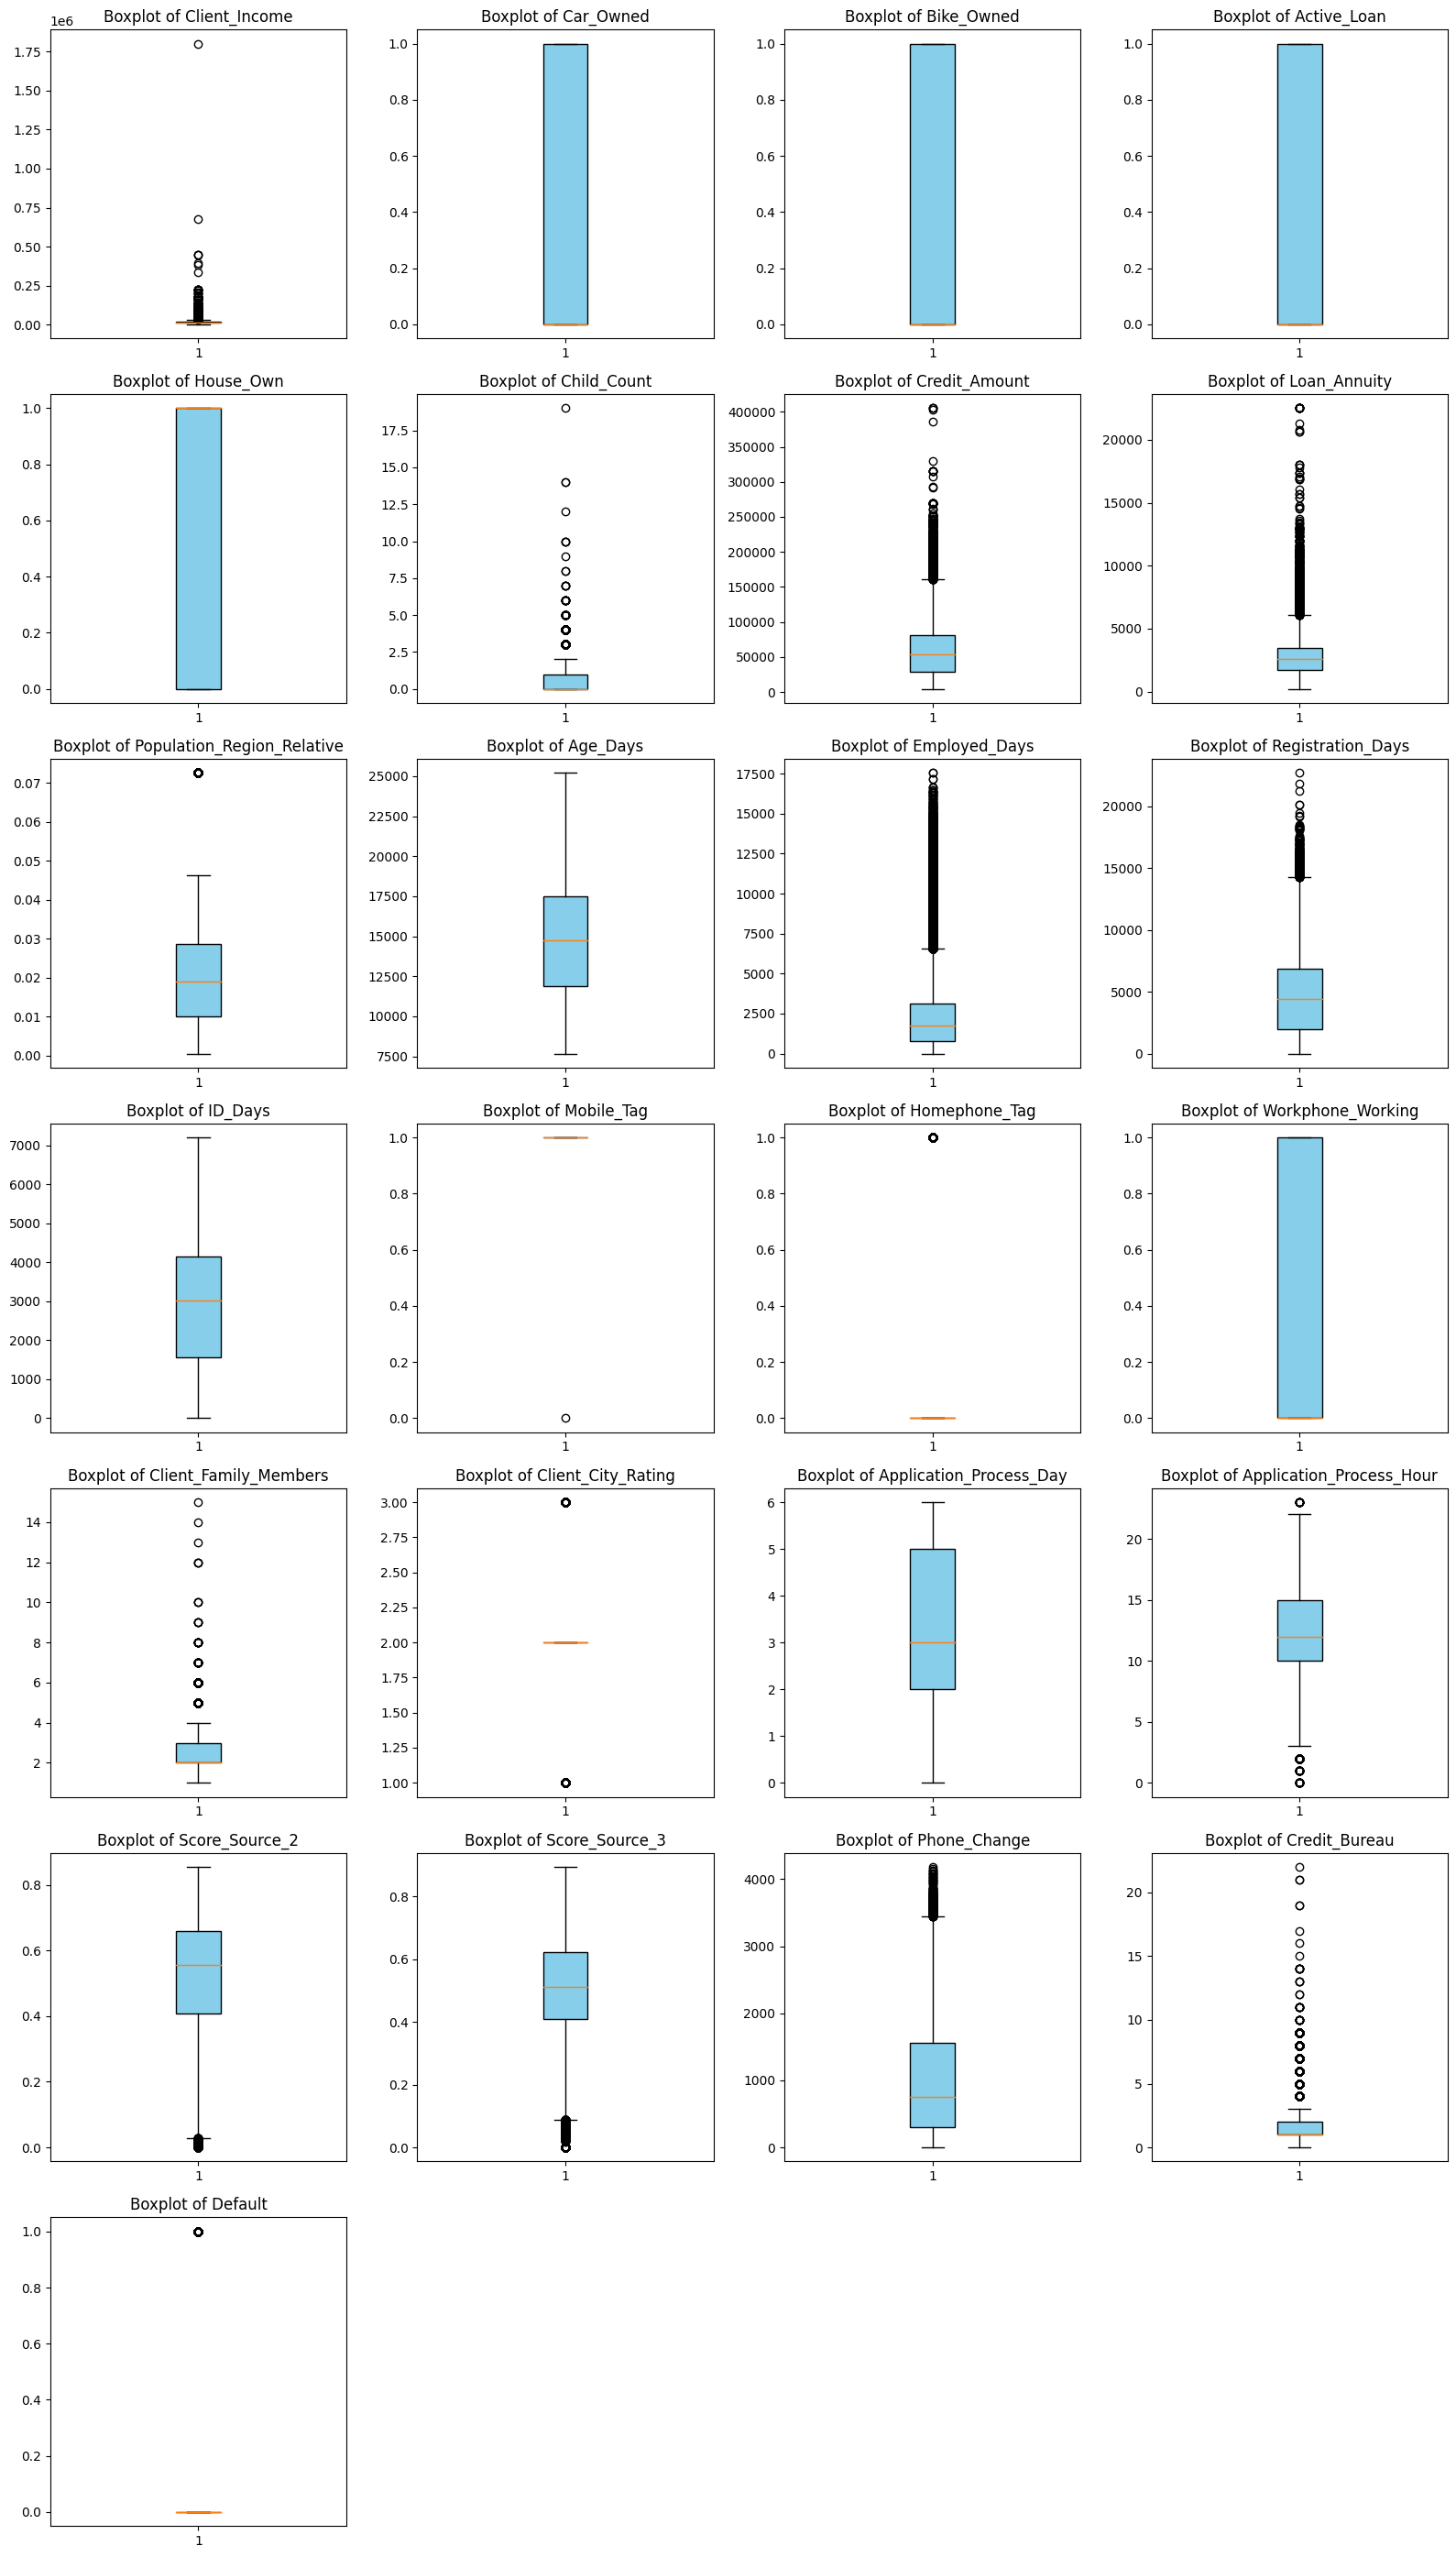

In [19]:
# let's consider numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns[1:]  # Exclude 'ID' column
numeric_data = data[numeric_cols]  # Subsetting numeric data

# Setting up the grid layout for multiple boxplots
num_cols = len(numeric_cols)
rows = (num_cols // 4) + (num_cols % 4 > 0)  # Arrange in 4 columns

plt.figure(figsize=(16, rows * 4)) 

# Let's plot boxplots for each numeric variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 4, i)  
    plt.boxplot(numeric_data[col].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col}")

plt.tight_layout() 
plt.show()

**Outliers in Key Variables:**
- Client_Income: High-income outliers indicate significant income disparity among clients.
- Credit_Amount: Large loan requests create a wide range with noticeable outliers.
- Loan_Annuity: Some extreme values, possibly due to incorrect entries or unique cases.
- Registration_Days: Unusual values suggest irregular registration patterns.
- Employed_Days: Outliers indicate excessively long job tenure, which may not be realistic.
- Family Members: A few cases show an unusually high number of family members.
- Phone_Change: Outliers suggest clients changing phones either too frequently or rarely.
- Child_Count: Some extreme values above 15, which may indicate data entry errors.
- Score_Source_3: Outliers appear in the top 25% percentile of values.
- Credit_Bureau: A subset of customers has an unusually high number of credit inquiries.

**Other Variables:**

Most categorical and binary variables (e.g., Car_Owned, Application_Process_Hour) have small ranges or discrete values, making outliers less impactful or requiring no special treatment.

In [20]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Mobile_Tag',
       'Homephone_Tag', 'Workphone_Working', 'Client_Family_Members',
       'Client_City_Rating', 'Application_Process_Day',
       'Application_Process_Hour', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Type_Organization', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default'],
      dtype='object')

In [21]:
def treat_outliers_iqr(df, column):
    """
    Treat outliers in a specified column using the IQR method.
    Values outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are capped.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name to treat outliers.
    
    Returns:
        pd.Series: The column with outliers capped.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    return df[column].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

In [22]:
# Columns to treat
columns_to_treat = ['Client_Income', 'Child_Count', 'Credit_Amount', 'Loan_Annuity', 'Employed_Days', 'Population_Region_Relative', 'Score_Source_2', 'Score_Source_3',
 'Employed_Days', 'Registration_Days', 'Phone_Change', 'Client_Family_Members', 'Score_Source_3', 'Credit_Bureau']

# Apply IQR-based outlier treatment
for col in columns_to_treat:
    data[col] = treat_outliers_iqr(data, col)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Univariate Analysis

#### 2.1.1 Numerical Columns

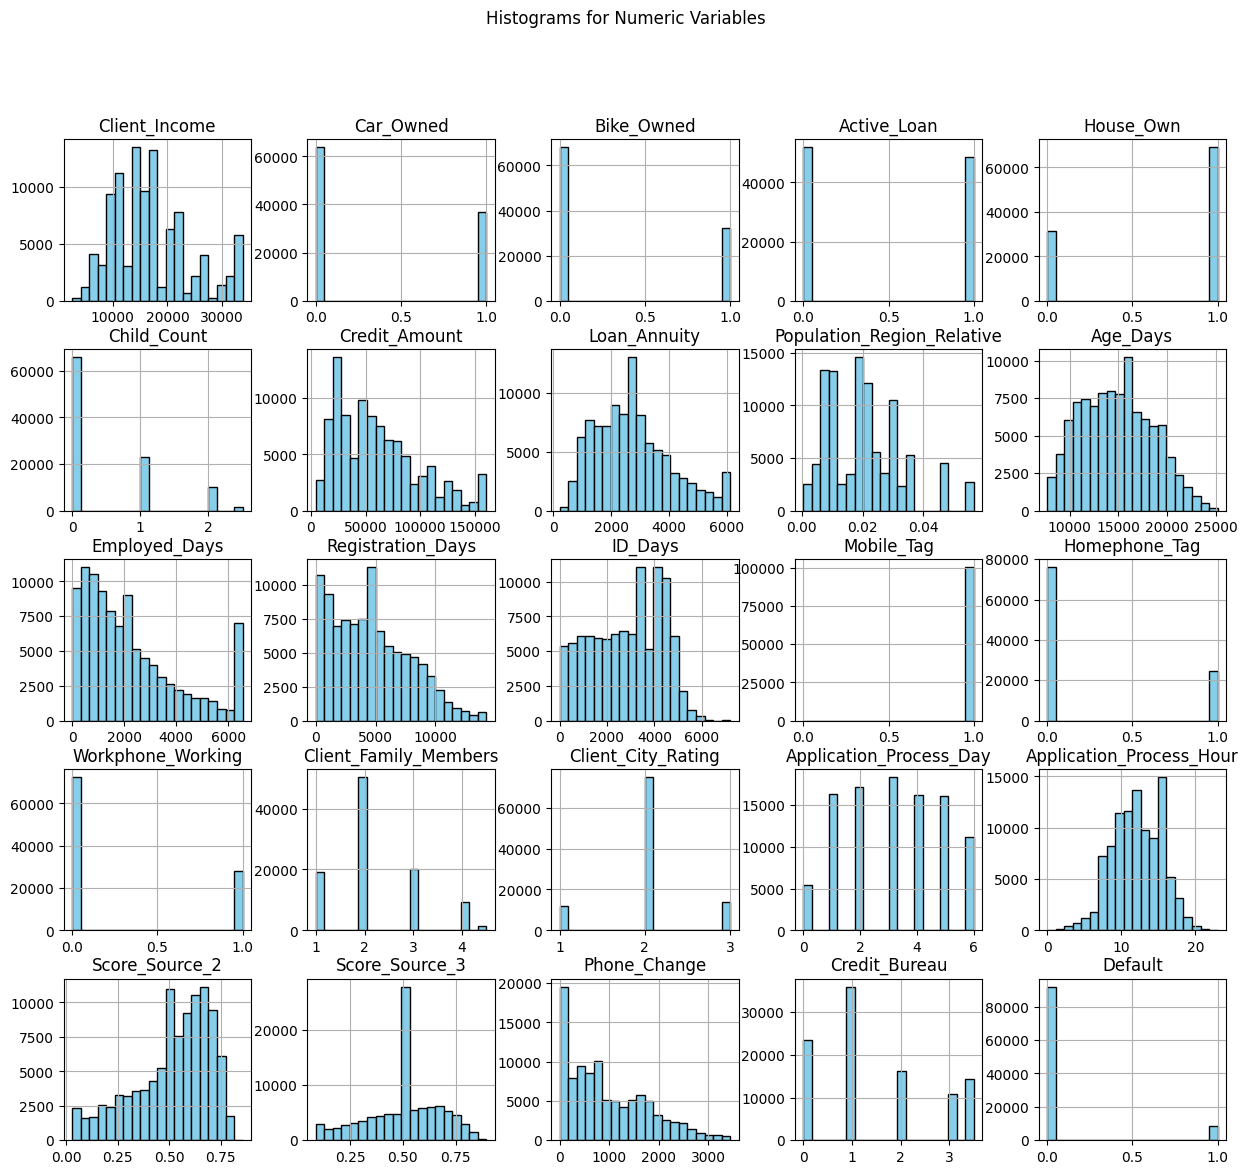

In [23]:
# Plot histograms for numeric variables
data[numeric_cols].hist(figsize=(15, 13), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Histograms for Numeric Variables")
plt.show()

#### 2.1.2 Categorical Variables

In [24]:
categorical_cols = data.select_dtypes(include=['object']).columns[:-2] # Exclude 'Type_Organization' column which has lot of categories & 'Default' 
categorical_cols

Index(['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Client_Permanent_Match_Tag'],
      dtype='object')

In [25]:
def analyze_categorical_column(data, col):
    """
    Generate an interactive bar plot for a categorical column using Plotly.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        col (str): The column name to analyze.

    Returns:
        None: Displays the interactive Plotly bar chart.
    """
    if col not in data.columns:
        print(f"Column '{col}' not found in the dataset.")
        return

    # Compute category counts & percentages
    category_counts = data[col].value_counts(normalize=True) * 100  # Get percentage
    category_counts_df = category_counts.reset_index()
    category_counts_df.columns = [col, "Percentage"]

    # Create the bar plot with subtle colors
    fig = px.bar(
        category_counts_df,
        x=col,
        y="Percentage",
        text="Percentage",
        color="Percentage",
        color_continuous_scale=px.colors.sequential.Teal,  # Subtle blue-green colors
        labels={col: col, "Percentage": "Percentage (%)"},
        title=f"Distribution of {col}",
    )

    # Improve layout
    fig.update_traces(
        texttemplate="%{text:.2f}%",  # Show percentages on bars
        textposition="outside"
    )
    
    fig.update_layout(
        xaxis_title=col,
        yaxis_title="% of Customers",
        xaxis_tickangle=-45,  # Rotate labels for better visibility
        showlegend=False,
        template="plotly_white",  # Clean background
        margin=dict(l=40, r=40, t=40, b=80)  # Adjust margins
    )

    # Show the plot
    fig.show()


In [26]:
data.select_dtypes(include=['object']).columns

Index(['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Type_Organization'],
      dtype='object')

In [27]:
analyze_categorical_column(data, "Client_Income_Type")

The column Client_Income_Type contains 8 unique categories, but some categories (e.g., Student, Unemployed, Maternity leave, Businessman) have very few records. These rare categories might not provide significant value in modeling and could be grouped into a single category to reduce dimensionality.

In [28]:
analyze_categorical_column(data, "Accompany_Client")

The column Accompany_Client has 7 unique categories, with the majority of clients applying alone (82,358) or with a relative (12,564). Rare categories like Group (85), Others (839), and invalid/placeholder values like ## (9) represent a small portion of the data and could be grouped into a single category, such as "Other", for simplification.

In [29]:
analyze_categorical_column(data, "Loan_Contract_Type")

In [30]:
data['Default'] = data['Default'].astype(str)
analyze_categorical_column(data, "Default")

The target variable Default is binary with two categories:

- 0 (No Default): 92,022 records (91.92%)
- 1 (Default): 8672 records (8.08%)
The dataset is imbalanced, with a significantly larger proportion of clients who did not default compared to those who did. This imbalance may affect model performance and may require techniques like oversampling (e.g., SMOTE), undersampling, or class weighting to address it during modeling.

In [31]:
analyze_categorical_column(data, "Loan_Contract_Type")

## 3. Data Processing

In [32]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Mobile_Tag',
       'Homephone_Tag', 'Workphone_Working', 'Client_Family_Members',
       'Client_City_Rating', 'Application_Process_Day',
       'Application_Process_Hour', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Type_Organization', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default'],
      dtype='object')

In [33]:
data.shape

(100692, 36)

In [34]:
data.select_dtypes(include=['object']).columns

Index(['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Type_Organization', 'Default'],
      dtype='object')

In [35]:
pd.crosstab(data['Accompany_Client'], data['Default'])

Default,0,1
Accompany_Client,,
##,7,2
Alone,75151,7207
Group,78,7
Kids,888,62
Others,764,75
Partner,3563,324
Relative,11569,995


Let's groups rare categories in Accompany_Client as "Other", keeping only 'Alone', 'Relative', and 'Partner' to reduce sparsity, simplify encoding, and prevent overfitting.

In [36]:
retain_categories = ['Alone', 'Relative', 'Partner']

# Replace all other categories with 'Other'
data["Accompany_Client"] = data["Accompany_Client"].apply(lambda x: x if x in retain_categories else 'Other')
data['Accompany_Client'].value_counts()

Accompany_Client
Alone       82358
Relative    12564
Partner      3887
Other        1883
Name: count, dtype: int64

In [37]:
pd.crosstab(data['Client_Income_Type'], data['Default'])

Default,0,1
Client_Income_Type,,
Businessman,1,0
Commercial,25641,2105
Govt Job,7814,484
Maternity leave,2,0
Retired,596,34
Service,57957,6049
Student,8,0
Unemployed,1,0


Let's groups rare income types as "Other", retaining only 'Service', 'Commercial', 'Retired', and 'Govt Job' to reduce sparsity, simplify encoding, and improve model generalization.

In [38]:
retain_categories = ['Service', 'Commercial', 'Retired', 'Govt Job']
    
# Replace all other categories with 'Other'
data["Client_Income_Type"] = data["Client_Income_Type"].apply(lambda x: x if x in retain_categories else 'Other')
data["Client_Income_Type"].value_counts()

Client_Income_Type
Service       64006
Commercial    27746
Govt Job       8298
Retired         630
Other            12
Name: count, dtype: int64

In [39]:
pd.crosstab(data['Client_Education'], data['Default'])

Default,0,1
Client_Education,,
Graduation,24416,1337
Graduation dropout,3440,324
Junior secondary,798,114
Post Grad,47,1
Secondary,63319,6896


Let's merge 'Post Grad' into 'Graduation' in Client_Education to simplify categories, reduce sparsity, and ensure consistency in education levels 

In [40]:
data["Client_Education"] = data["Client_Education"].replace({'Post Grad': 'Graduation'})
data["Client_Education"].value_counts()

Client_Education
Secondary             70215
Graduation            25801
Graduation dropout     3764
Junior secondary        912
Name: count, dtype: int64

In [41]:
pd.crosstab(data['Client_Marital_Status'], data['Default'])

Default,0,1
Client_Marital_Status,,
D,5644,506
M,70354,6421
S,13551,1576
W,2471,169


In [42]:
pd.crosstab(data['Client_Gender'], data['Default'])

Default,0,1
Client_Gender,,
Female,33435,3820
Male,58582,4852
XNA,3,0


Let's  replaces 'XNA' with 'Male' in Client_Gender to handle ambiguous entries, ensure consistency, and avoid missing values in gender

In [43]:
data["Client_Gender"] = data["Client_Gender"].replace({'XNA': 'Male'})
data["Client_Gender"].value_counts()

Client_Gender
Male      63437
Female    37255
Name: count, dtype: int64

In [44]:
pd.crosstab(data['Loan_Contract_Type'], data['Default'])

Default,0,1
Loan_Contract_Type,,
CL,82752,8084
RL,9268,588


In [45]:
pd.crosstab(data['Client_Housing_Type'], data['Default'])

Default,0,1
Client_Housing_Type,,
Family,5060,647
Home,81153,7391
Municipal,3134,310
Office,801,59
Rental,1519,224
Shared,353,41


In [46]:
pd.crosstab(data['Client_Permanent_Match_Tag'], data['Default'])

Default,0,1
Client_Permanent_Match_Tag,,
No,7771,1068
Yes,84249,7604


In [47]:
pd.crosstab(data['Client_Contact_Work_Tag'], data['Default'])

Default,0,1
Client_Contact_Work_Tag,,
No,19708,2120
Yes,72312,6552


In [48]:
pd.crosstab(data['Type_Organization'], data['Default'])
del data['Type_Organization'] # as it has lot of categories

In [49]:
data.shape

(100692, 35)

In [50]:
data['Default'] = data['Default'].replace({'N': 0, 'Y': 1})
data['Default'].value_counts()

Default
0    92020
1     8672
Name: count, dtype: int64

## 4. Bivariate Analysis

In [51]:
def bivariate_categorical_plot(data, column, target_col="Default"):
    """
    Perform bivariate analysis for a categorical feature against the target variable,
    ensuring graphs are visible when exporting to HTML.

    Parameters:
        data (pd.DataFrame): The dataset.
        column (str): The categorical column to analyze.
        target_col (str): The target variable (default: "Default").

    Returns:
        None (Displays an interactive bar chart in the notebook).
    """
    # Convert target variable to categorical labels
    data[target_col] = data[target_col].replace({1: "Defaulter", 0: "Non-Defaulter"})

    # Aggregate counts for each category split by Default
    category_counts = data.groupby([column, target_col]).size().reset_index(name="Count")

    # Calculate percentage per category
    total_counts = category_counts.groupby(column)["Count"].transform("sum")
    category_counts["Percentage"] = (category_counts["Count"] / total_counts * 100).round(1)

    # Order categories in descending order
    category_order = category_counts.groupby(column)["Count"].sum().sort_values(ascending=False).index
    category_counts[column] = pd.Categorical(category_counts[column], categories=category_order, ordered=True)

    # Create an interactive bar chart
    fig = px.bar(
        category_counts, 
        x=column, 
        y="Count", 
        color=target_col, 
        barmode="group",
        text=category_counts["Percentage"].astype(str) + '%',  
        title=f"Bivariate Analysis: {column} vs Loan Default",
        labels={column: column, "Count": "Number of Customers"},
        color_discrete_map={"Defaulter": "#E63946", "Non-Defaulter": "#3D405B"}  # Subtle pastel colors
    )

    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title=column, 
        yaxis_title="Number of Customers",
        legend_title="Loan Status",
        xaxis=dict(showgrid=False, tickangle=-45),  # Rotate labels for clarity
        yaxis=dict(showgrid=False),
        plot_bgcolor="#F5F5F5",  
        paper_bgcolor="#F5F5F5",
        margin=dict(l=40, r=40, t=60, b=80)
    )

    # Ensure text labels are properly displayed
    fig.update_traces(textposition="outside")

    # Show the figure
    fig.show()

In [52]:
bivariate_categorical_plot(data, "Client_Education")

In [53]:
bivariate_categorical_plot(data, "Client_Housing_Type")

In [54]:
bivariate_categorical_plot(data, "Client_Gender")

In [55]:
bivariate_categorical_plot(data, "Client_Marital_Status")

In [56]:
bivariate_categorical_plot(data, "Loan_Contract_Type")

In [57]:
bivariate_categorical_plot(data, "Client_Income_Type")

## 5. Hypothesis testing

### 5.1 Business Justification: Income vs Loan Default
We assume that clients with higher income are less likely to default on their loans. To test this, we perform a two-sample t-test to compare the mean incomes of defaulters vs non-defaulters.

- Null Hypothesis (H₀): The mean income of defaulters and non-defaulters is the same.
- Alternative Hypothesis (H₁): The mean income of defaulters is different from that of non-defaulters.

T-test: A t-test is a statistical test used to compare the means of two groups to determine if they are significantly different.

In [58]:
data['Default'] = data['Default'].replace({'0': 'Non-Defaulter', '1': 'Defaulter'})
data['Default'].value_counts()


Default
Non-Defaulter    92020
Defaulter         8672
Name: count, dtype: int64

In [59]:
# Splitting data into defaulters and non-defaulters
income_defaulters = data[data["Default"] == 'Defaulter']["Client_Income"]
income_non_defaulters = data[data["Default"] == 'Non-Defaulter']["Client_Income"]

# Performing the two-sample t-test
t_stat, p_value = ttest_ind(income_defaulters, income_non_defaulters, equal_var=False)

# Printing results
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Income distribution differs between defaulters and non-defaulters.")
else:
    print("Fail to reject the null hypothesis: No significant difference in income between defaulters and non-defaulters.")


T-Statistic: -12.0840
P-Value: 0.0000
Reject the null hypothesis: Income distribution differs between defaulters and non-defaulters.


Since the p-value is very small (0.00001), we reject H₀, meaning income is a significant factor in loan default. The negative t-statistic suggests that defaulters tend to have lower incomes compared to non-defaulters.  Lower-income clients are at a higher risk of default on their vehicle loans.

The NBFI should consider stricter lending criteria or adjust interest rates for low-income applicants to mitigate default risk.

### 5.2 Business Justification: Credit Inquiries and Default Rates
We assume that clients who have more credit inquiries in the past year (i.e., higher Credit_Bureau values) are more likely to default.
We perform a Mann-Whitney U Test, a non-parametric test, since credit inquiries are often skewed and not normally distributed.

- Null Hypothesis (H₀): The distribution of credit inquiries (Credit_Bureau) is the same for defaulters and non-defaulters.
- Alternative Hypothesis (H₁): The distribution of credit inquiries differs between defaulters and non-defaulters.

In [60]:
# Splitting data into defaulters and non-defaulters
credit_defaulters = data[data["Default"] == 'Defaulter']["Credit_Bureau"].dropna()
credit_non_defaulters = data[data["Default"] == 'Non-Defaulter']["Credit_Bureau"].dropna()

# Performing Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(credit_defaulters, credit_non_defaulters, alternative='two-sided')

# Printing results
print(f"U-Statistic: {u_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Credit history differs significantly between defaulters and non-defaulters.")
else:
    print("Fail to reject the null hypothesis: No significant difference in credit history between defaulters and non-defaulters.")

U-Statistic: 409782991.0000
P-Value: 0.0000
Reject the null hypothesis: Credit history differs significantly between defaulters and non-defaulters.


Since p-value < 0.05, we reject the null hypothesis (H₀). This means credit history is significantly different between defaulters and non-defaulters. Clients who default tend to have a different pattern of credit inquiries compared to those who do not.

NBFI can use this insight to refine loan approval strategies and implement stricter credit screening for high-risk applicants.

## 6. Feature Engineering

To better assess a client's financial capacity and loan repayment risk, we derived the following three key financial ratios

**1. Financial Ratios**

1. Debt_Income_Ratio= Client_Income / Credit_Amount

This ratio represents how much debt a client is taking compared to their income. Higher values indicate that the client is taking on a larger loan relative to their income, which may signal higher risk of default.

2. Annuity_Income_Ratio= Client_Income / Loan_Annuity

This ratio measures the proportion of a client’s income that goes into loan repayment (annuity payments). Higher values indicate that a significant portion of the income is being allocated to loan payments, increasing default risk if the client has limited disposable income.

3. Loan_Duration= Loan_Annuity / Credit_Amount

This feature estimates how long (in months) it will take to repay the loan, assuming constant annuity payments. Longer durations suggest a higher burden on the client, potentially increasing the likelihood of default.
​
​

In [61]:
data["Debt_Income_Ratio"] = data["Credit_Amount"] / data["Client_Income"]
data["Annuity_Income_Ratio"] = data["Loan_Annuity"] / data["Client_Income"]
data["Loan_Duration"] = data["Credit_Amount"] / data["Loan_Annuity"]

**2. Employment & Stability Features**

1. Age_Years= Age_Days/ 365

Converts client age from days to years for easier interpretation.

2. Employed_Years = Employed_Days/ 365

Measures how many years the client has been employed. Clients with longer employment history tend to have more financial stability, reducing default risk.

3. Registration_Years = Registration_Days / 365

​Represents how long the client has been registered at their current address. Shorter durations may indicate higher mobility or instability, which can be a risk factor for loan default.

4. ID_Years= ID_Days / 365

Represents how long ago the client changed their identity document. Frequent ID changes might be a red flag for fraud or unstable financial history.

In [62]:
data["Age_Years"] = data["Age_Days"] // 365
data["Employed_Years"] = data["Employed_Days"].apply(lambda x: x // 365 if x > 0 else 0)
data["Registration_Years"] = data["Registration_Days"] // 365
data["ID_Years"] = data["ID_Days"] // 365


**3. Interaction Features**

1. Employment_to_Age_Ratio= Employed_Years / Age_Years

​Measures the proportion of a client's life spent working. Higher values suggest longer employment stability, which may correlate with lower loan default risk.

2. Credit_to_Age_Ratio= Credit_Amount/ Age_Years

Represents how much loan credit a client has taken relative to their age. Higher values suggest that a client is taking on a large amount of debt at a younger age, which may indicate higher financial risk.

3. Family_Size=Client_Family_Members + Child_Count
​
Calculates the total number of dependents in a client’s household. Larger family sizes may indicate higher financial obligations, increasing the risk of default due to greater household expenses.

In [63]:
data["Employment_to_Age_Ratio"] = data["Employed_Years"] / data["Age_Years"]
data["Credit_to_Age_Ratio"] = data["Credit_Amount"] / data["Age_Years"]
data["Family_Size"] = data["Client_Family_Members"] + data["Child_Count"]
data.head()
data.shape

(100692, 45)

In [64]:
data['Default'].value_counts()

Default
Non-Defaulter    92020
Defaulter         8672
Name: count, dtype: int64

In [65]:
# dropping unnecessary columns
data.drop(columns={'Population_Region_Relative','Child_Count', 'Age_Days', 'Employed_Days', 'ID_Days',
                   'Registration_Days', 'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working'}, inplace=True)
data.shape

(100692, 36)

## 7.Undersampling

Our dataset is highly imbalanced, with non-defaulters (majority class) significantly outnumbering defaulters (minority class). This imbalance can lead to a biased model, where it predicts non-defaults more often, failing to identify high-risk clients accurately.

**Why Undersampling?**

- Avoids Overfitting to Majority Class: By reducing the number of non-defaulters, we balance the dataset, ensuring the model learns patterns from both classes equally.
- Prevents Computational Overhead: Undersampling reduces the dataset size, making training faster and memory-efficient compared to oversampling techniques.
- Improves Predictive Performance on Defaulters: With a balanced dataset, the model gains better sensitivity (recall) towards defaulters, which is critical for risk management.

**Approach:**

- Retaining 50% of the majority class (non-defaulters) ensures we still have a significant amount of data while improving class balance.
- We randomly select a subset of non-defaulters to match a closer ratio with defaulters, ensuring a fair representation of both groups.

In [66]:
# Step 1: Separate majority and minority classes
data_majority = data[data['Default'] == 'Non-Defaulter']
data_minority = data[data['Default'] == 'Defaulter']

# Step 2: Define the percentage for undersampling 
undersample_percent = 0.5  # Retain 50% of majority class

# Calculate the number of records to keep from the majority class
n_majority_to_keep = int(len(data_majority) * undersample_percent)
print(n_majority_to_keep)

46010


In [67]:

# Step 3: Downsample the majority class
data_majority_downsampled = resample(
    data_majority,
    replace=False,  # Sample without replacement
    n_samples=n_majority_to_keep,  
    random_state=42  
)

# Step 4: Combine the downsampled majority class with the minority class
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Step 5: Shuffle the combined dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Check the new class distribution
print("Class distribution after percentage-based undersampling:\n", data_balanced['Default'].value_counts())

Class distribution after percentage-based undersampling:
 Default
Non-Defaulter    46010
Defaulter         8672
Name: count, dtype: int64


In [68]:
analyze_categorical_column(data_balanced, "Default")

## 8. One Hot Encoding

In [69]:
data_balanced["Default"] = data_balanced["Default"].replace({"Non-Defaulter": 0, "Defaulter": 1})
data_balanced["Default"].value_counts()

Default
0    46010
1     8672
Name: count, dtype: int64

In [70]:
# Separate features and target
X = data_balanced.drop(columns=['Default', 'ID'])
y = data_balanced['Default']

let's converts categorical variables into one-hot encoded numerical values, dropping the first category to prevent multicollinearity

In [71]:
X = pd.get_dummies(X, drop_first=True)  # Convert categorical features to numerical

## 9. Train Test SPlit

The train-test split divides the dataset into 80% training and 20% testing sets, ensuring stratified sampling (stratify=y) to maintain class distribution, and setting a random state (42) for reproducibility

In [72]:
# Train-Test Split (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train shape: (43745, 47)
X_test shape: (10937, 47)
y_train: (43745,)
y_test: (10937,)


### Standardization

Standardization (Z-score normalization) is a scaling technique that transforms numerical features so that they have:

- Mean (μ) = 0
- Standard deviation (σ) = 1

**Why Standardization?**

- Improves Model Performance
- Prevents Bias Toward Large Values
- Speeds Up Gradient Descent

In [73]:
# Selecting only numerical columns for scaling
numerical_cols = X_train.select_dtypes(include=["number"]).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform only numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [112]:
numerical_cols

Index(['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own',
       'Credit_Amount', 'Loan_Annuity', 'Client_Family_Members',
       'Client_City_Rating', 'Application_Process_Day',
       'Application_Process_Hour', 'Score_Source_2', 'Score_Source_3',
       'Phone_Change', 'Credit_Bureau', 'Debt_Income_Ratio',
       'Annuity_Income_Ratio', 'Loan_Duration', 'Age_Years', 'Employed_Years',
       'Registration_Years', 'ID_Years', 'Employment_to_Age_Ratio',
       'Credit_to_Age_Ratio', 'Family_Size'],
      dtype='object')

## 10. Model Building

### 10.1. Base Model Logistic Regression

In our vehicle loan default prediction case, Logistic Regression is a strong choice because it is:
1. Ideal for Binary Classification

2. Provides Probability Estimates for Risk Assessment : This helps the NBFI assess the likelihood of a client defaulting, allowing for risk-based decision-making (e.g., setting thresholds for loan approvals).

3. Handles Imbalanced Data with class_weight='balanced': The model adjusts the decision boundary to give equal importance to both classes, preventing bias toward non-defaulters.

4. Feature Interpretability for Business Insights: It provides coefficients, allowing us to understand which features (e.g., Debt-to-Income Ratio, Credit Bureau Inquiries) have the strongest impact on default risk.

5. Efficient & Works Well with Standardized Features: Since we have standardized numerical features, Logistic Regression benefits from better optimization and faster convergence. The L1 penalty (penalty='l1') helps in feature selection by shrinking less important features to zero, improving interpretability.

In [74]:
#Training Logistic Regression Model
random.seed(42)

# L1 Regularization helps remove irrelevant features.
# Balanced class weighting ensures better handling of defaulters.
# Regularization (C=0.01) prevents overfitting, improving model generalization

model = LogisticRegression(penalty='l1', C=0.01, max_iter=500, class_weight='balanced', solver='liblinear', random_state=42)

model.fit(X_train, y_train)

# Step 7: Make Predictions
y_pred = model.predict(X_test)

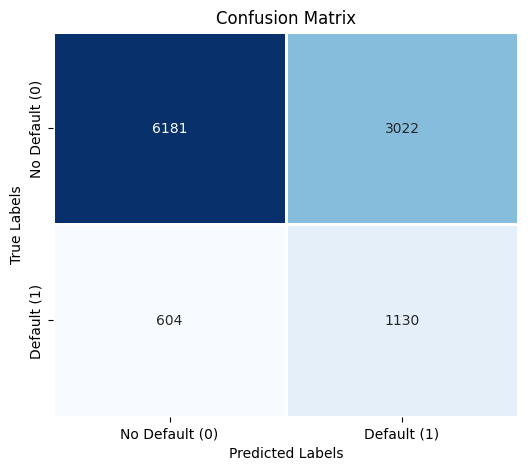

In [75]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False, xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])

# Formatting
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

- 6170 True Negatives (TN) → Model correctly identified these customers as non-defaulters.
- 1133 True Positives (TP) → Model correctly identified these customers as defaulters.
- 601 False Negatives (FN) → These defaulters were misclassified as non-defaulters, meaning some risky clients might receive loans.
- 3033 False Positives (FP) → These non-defaulters were misclassified as defaulters, meaning some good clients might get wrongly rejected.

### 10.2 Model Evaluation Functions

In [99]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates a trained model on both train and test datasets.

    Parameters:
    - model: Trained model (e.g.LogisticRegression, XGBoost, RandomForest etc.)
    - X_train, y_train: Training data
    - X_test, y_test: Test data

    Returns:
    - Dictionary containing train and test metrics
    """
    metrics = {}

    #Train Predictions
    train_pred = model.predict(X_train)
    train_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None

    #Test Predictions
    test_pred = model.predict(X_test)
    test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
        "Train": [
            accuracy_score(y_train, train_pred),
            precision_score(y_train, train_pred),
            recall_score(y_train, train_pred),
            f1_score(y_train, train_pred),
            roc_auc_score(y_train, train_prob) if train_prob is not None else "N/A"
        ],
        "Test": [
            accuracy_score(y_test, test_pred),
            precision_score(y_test, test_pred),
            recall_score(y_test, test_pred),
            f1_score(y_test, test_pred),
            roc_auc_score(y_test, test_prob) if test_prob is not None else "N/A"
        ]
    }

    df_metrics = pd.DataFrame(metrics)

    conf_matrix = confusion_matrix(y_test, test_pred)
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False, xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])

    # Formatting
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return df_metrics

In [100]:
def plot_roc_curve(model, X_test, y_test):
    """
    Plots the ROC Curve for a given model.

    Parameters:
    - model: Trained model (e.g., XGBoost, LightGBM, LogisticRegression)
    - X_test: Test features
    - y_test: True test labels
    """
    # Compute ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    if y_prob is None:
        print(" Model does not support probability predictions.")
        return

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [78]:
evaluate_model(model, X_train, y_train, X_test, y_test)

,Metric,Train,Test
0,Accuracy,0.672168,0.668465
1,Precision,0.277193,0.272158
2,Recall,0.663736,0.651672
3,F1 Score,0.391066,0.383962
4,ROC-AUC,0.729234,0.717302


- Accuracy (~67%): The model correctly predicts loan defaults 67% of the time, showing moderate performance.
- Precision (~27%): Only 27% of predicted defaulters are actually defaulters, indicating high false positives (over-predicting defaults).
- Recall (~65%): The model captures ~65% of actual defaulters, meaning some high-risk clients are still missed.
- F1 Score (~38%): A balance between precision and recall, indicating moderate predictive power.
- ROC-AUC (~72%): The model differentiates defaulters from non-defaulters 72% of the time, showing decent discrimination ability-

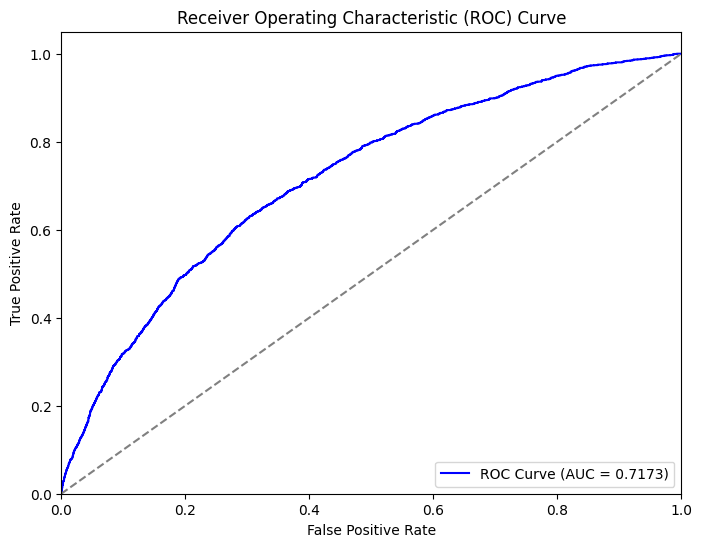

In [79]:
plot_roc_curve(model, X_test, y_test)

The ROC curve is a graphical representation of a classification model’s ability to distinguish between classes (defaulters vs. non-defaulters) at different thresholds. 

- X-axis (False Positive Rate - FPR): The proportion of non-defaulters incorrectly classified as defaulters.
- Y-axis (True Positive Rate - TPR): The proportion of actual defaulters correctly identified.
- Diagonal Line (Random Guessing - 50%): Represents a model with no discrimination ability (random chance).

The model performs better than random guessing (AUC > 0.5) but has room for improvement.

In [80]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_[0])  # Absolute values of coefficients
}).sort_values(by='Importance', ascending=False)

In [81]:
feature_importance

,Feature,Importance
12,Score_Source_3,0.471080
11,Score_Source_2,0.396851
38,Client_Gender_Male,0.353830
34,Client_Education_Secondary,0.349880
39,Loan_Contract_Type_RL,0.309787
19,Employed_Years,0.175477
45,Client_Permanent_Match_Tag_Yes,0.164943
1,Car_Owned,0.111795
16,Annuity_Income_Ratio,0.093053
8,Client_City_Rating,0.086179


**Feature Selection Strategy:**

- Remove features with zero importance to simplify the model and improve efficiency.
- Retain top-ranked features to maintain prediction accuracy.
- Consider re-evaluating moderately important features to check for redundancy.

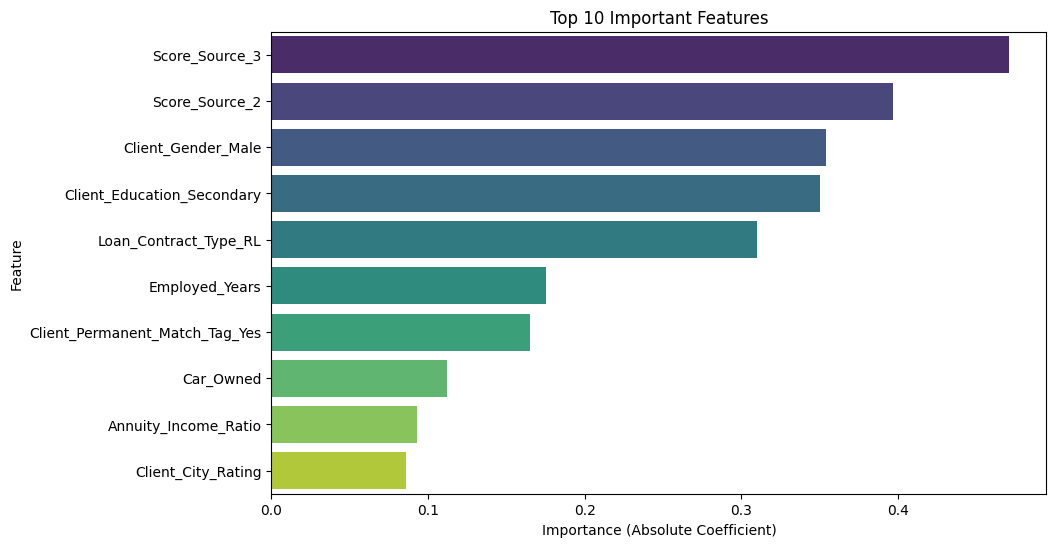

In [82]:
# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Important Features')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.show()

- Score_Source_3 and Score_Source_2 are the most critical predictors, indicating external credit scores play a significant role in assessing risk.
- Client_Education_Secondary, Client_Gender_Male, and Loan_Contract_Type_RL also contribute significantly, suggesting that education level, gender, and loan type impact default probability.
- Employed_Days and Client_Permanent_Match_Tag_Yes highlight the importance of employment history and address stability in loan repayment behavior.
- Features like Car_Owned, Client_City_Rating, and Loan_Annuity show moderate influence in determining default risk.

### 1.1 Logistic Regression Model (L1 Regularization - Feature Selection)

Dropping Low-Impact Features → Removing low-importance features to improve model efficiency and reduce noise. This helps in enhancing predictive power by focusing on more meaningful variables.

In [83]:
data_balanced.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Credit_Amount', 'Loan_Annuity', 'Accompany_Client',
       'Client_Income_Type', 'Client_Education', 'Client_Marital_Status',
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Client_Family_Members', 'Client_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Score_Source_2', 'Score_Source_3', 'Phone_Change', 'Credit_Bureau',
       'Default', 'Debt_Income_Ratio', 'Annuity_Income_Ratio', 'Loan_Duration',
       'Age_Years', 'Employed_Years', 'Registration_Years', 'ID_Years',
       'Employment_to_Age_Ratio', 'Credit_to_Age_Ratio', 'Family_Size'],
      dtype='object')

In [85]:
imp_cols = [ "Score_Source_2", "Score_Source_3", "Client_Gender",
 "Client_Education", "Loan_Contract_Type", "Employed_Years", "Client_Permanent_Match_Tag", "Car_Owned", "Annuity_Income_Ratio", "ID_Years",
   "Client_Income_Type", "Client_Housing_Type", "Client_Marital_Status", "Credit_to_Age_Ratio", "Phone_Change", "Age_Years", "Loan_Duration", "House_Own", "Default"]

data_balanced = data_balanced[imp_cols]
data_balanced.shape

(54682, 19)

In [86]:
data_balanced.select_dtypes(include='number').columns

Index(['Score_Source_2', 'Score_Source_3', 'Employed_Years', 'Car_Owned',
       'Annuity_Income_Ratio', 'ID_Years', 'Credit_to_Age_Ratio',
       'Phone_Change', 'Age_Years', 'Loan_Duration', 'House_Own', 'Default'],
      dtype='object')

In [87]:
numerical_clolumns = ['Score_Source_2', 'Score_Source_3', 'Employed_Years', 'Car_Owned',
       'Annuity_Income_Ratio', 'ID_Years', 'Credit_to_Age_Ratio',
       'Phone_Change', 'Age_Years', 'Loan_Duration', 'House_Own']

In [88]:
# Separate features and target
X = data_balanced.drop(columns=['Default'])
y = data_balanced['Default']

X = pd.get_dummies(X, drop_first=True)  # Convert categorical features to numerical

# Train-Test Split (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)                                                                                                                            
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train shape: (43745, 29)
X_test shape: (10937, 29)
y_train: (43745,)
y_test: (10937,)


In [89]:
### Standardization

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform only numerical columns
X_train[numerical_clolumns] = scaler.fit_transform(X_train[numerical_clolumns])
X_test[numerical_clolumns] = scaler.transform(X_test[numerical_clolumns])

In [113]:
X_train.columns

Index(['Score_Source_2', 'Score_Source_3', 'Employed_Years', 'Car_Owned',
       'Annuity_Income_Ratio', 'ID_Years', 'Credit_to_Age_Ratio',
       'Phone_Change', 'Age_Years', 'Loan_Duration', 'House_Own',
       'Client_Gender_Male', 'Client_Education_Graduation dropout',
       'Client_Education_Junior secondary', 'Client_Education_Secondary',
       'Loan_Contract_Type_RL', 'Client_Permanent_Match_Tag_Yes',
       'Client_Income_Type_Govt Job', 'Client_Income_Type_Other',
       'Client_Income_Type_Retired', 'Client_Income_Type_Service',
       'Client_Housing_Type_Home', 'Client_Housing_Type_Municipal',
       'Client_Housing_Type_Office', 'Client_Housing_Type_Rental',
       'Client_Housing_Type_Shared', 'Client_Marital_Status_M',
       'Client_Marital_Status_S', 'Client_Marital_Status_W'],
      dtype='object')

In [90]:
random.seed(42)

model = LogisticRegression(penalty='l1', C=0.01, max_iter=500, class_weight='balanced', solver='liblinear', random_state=42)

model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=500, penalty='l1',
                   random_state=42, solver='liblinear')

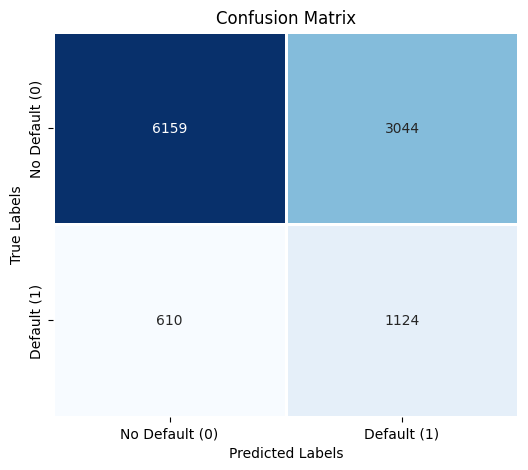

,Metric,Train,Test
0,Accuracy,0.671985,0.665905
1,Precision,0.276656,0.269674
2,Recall,0.661574,0.648212
3,F1 Score,0.390157,0.380888
4,ROC-AUC,0.728079,0.716073


In [101]:
evaluate_model(model, X_train, y_train, X_test, y_test)

- Accuracy (~67%) remains stable, indicating consistent model performance.
- Precision (~27%) slightly improved, meaning fewer false positives (better at predicting defaulters correctly).
- Recall (~65%) remains strong, ensuring defaulters are still well captured.
- F1 Score (~39%) shows a better balance between precision and recall.
- ROC-AUC (~71.8%) remains stable, confirming the model still effectively distinguishes defaulters from non-defaulters.

In [92]:
import pickle
with open("../model/scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

In [93]:
import pickle

# Example: Assume `model` is your trained model
with open("../model/logistic_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Model saved as 'logistic_model.pkl'")

Model saved as 'logistic_model.pkl'


In [94]:
X_train.columns

Index(['Score_Source_2', 'Score_Source_3', 'Employed_Years', 'Car_Owned',
       'Annuity_Income_Ratio', 'ID_Years', 'Credit_to_Age_Ratio',
       'Phone_Change', 'Age_Years', 'Loan_Duration', 'House_Own',
       'Client_Gender_Male', 'Client_Education_Graduation dropout',
       'Client_Education_Junior secondary', 'Client_Education_Secondary',
       'Loan_Contract_Type_RL', 'Client_Permanent_Match_Tag_Yes',
       'Client_Income_Type_Govt Job', 'Client_Income_Type_Other',
       'Client_Income_Type_Retired', 'Client_Income_Type_Service',
       'Client_Housing_Type_Home', 'Client_Housing_Type_Municipal',
       'Client_Housing_Type_Office', 'Client_Housing_Type_Rental',
       'Client_Housing_Type_Shared', 'Client_Marital_Status_M',
       'Client_Marital_Status_S', 'Client_Marital_Status_W'],
      dtype='object')

In [95]:
X_train.dtypes

Score_Source_2                         float64
Score_Source_3                         float64
Employed_Years                         float64
Car_Owned                              float64
Annuity_Income_Ratio                   float64
ID_Years                               float64
Credit_to_Age_Ratio                    float64
Phone_Change                           float64
Age_Years                              float64
Loan_Duration                          float64
House_Own                              float64
Client_Gender_Male                        bool
Client_Education_Graduation dropout       bool
Client_Education_Junior secondary         bool
Client_Education_Secondary                bool
Loan_Contract_Type_RL                     bool
Client_Permanent_Match_Tag_Yes            bool
Client_Income_Type_Govt Job               bool
Client_Income_Type_Other                  bool
Client_Income_Type_Retired                bool
Client_Income_Type_Service                bool
Client_Housin

### 10.2 Random Forest Classifier

Random Forest: A Powerful Ensemble Model

A supervised learning algorithm that builds multiple decision trees and combines their outputs for better predictions.
Uses bootstrap aggregation (bagging) to reduce overfitting and improve generalization. 

Why Use Random Forest?
- Handles Non-Linearity – Captures complex relationships in data.
- Reduces Overfitting – Averages multiple trees for better generalization.
- Feature Importance – Identifies key predictors in the dataset.
- Works Well with Imbalanced Data – class_weight='balanced' ensures fair learning.
- Probabilistic Predictions – Outputs default risk scores for better decision-making.

In [96]:
# Training a Random Forest Classifier

# Balanced weighting improves defaulter detection in imbalanced data.
# Shallow trees (max_depth=6) prevent overfitting while capturing useful patterns.
# More trees (n_estimators=600) enhance stability, reducing variance in predictions.

rf_model = RandomForestClassifier(n_estimators=600,max_depth=6, min_samples_leaf=8,random_state=42, class_weight='balanced')  # Adjust for class imbalance
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=8,
                       n_estimators=600, random_state=42)

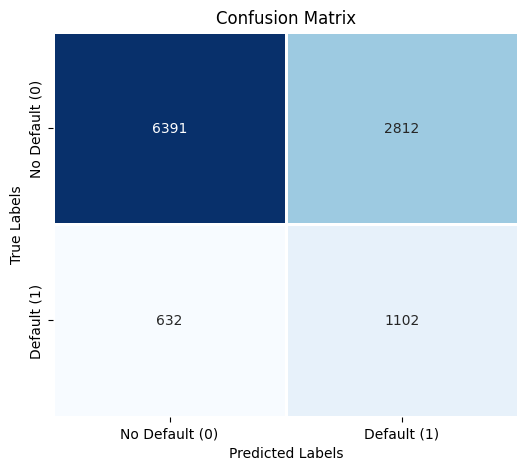

,Metric,Train,Test
0,Accuracy,0.701246,0.685106
1,Precision,0.301393,0.281553
2,Recall,0.670510,0.635525
3,F1 Score,0.415858,0.390227
4,ROC-AUC,0.755448,0.723265


In [102]:
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

 - Higher Accuracy (68%) → Better overall predictions.
- Improved Precision (27%) → Slight increase in correctly identifying defaulters.
- Lower Recall (61%) → Captures fewer defaulters compared to Logistic Regression.
- F1 Score (38%) → Balance between precision and recall remains similar.
- Higher ROC-AUC (72%) → Better ability to differentiate defaulters from non-defaulters.

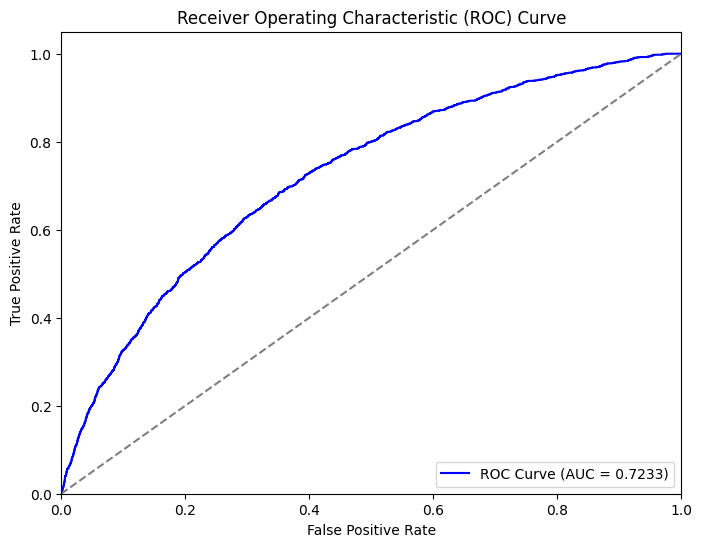

In [104]:
plot_roc_curve(rf_model, X_test, y_test)

AUC = 0.7179, meaning the model correctly distinguishes defaulters from non-defaulters ~71.8% of the time.

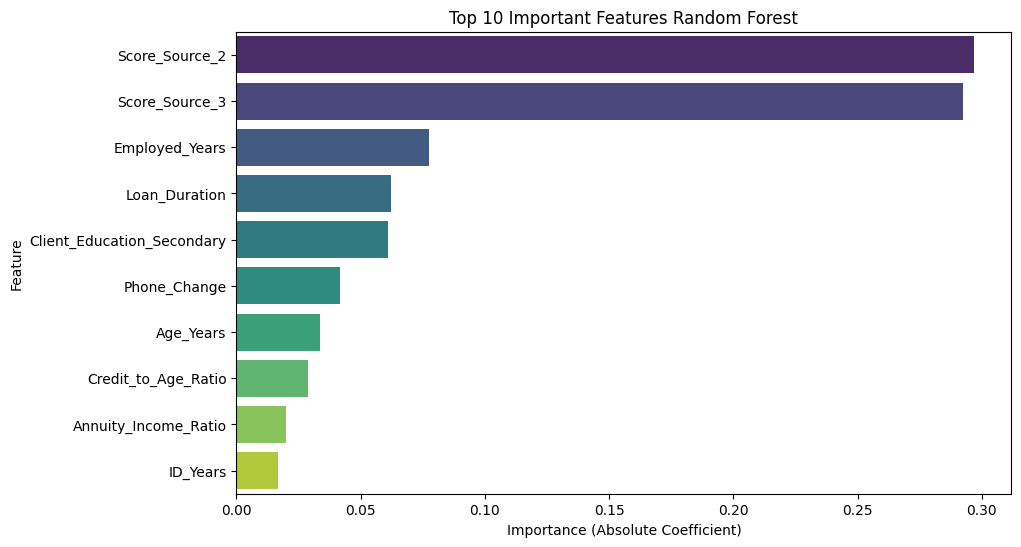

In [109]:
feature_importance_rf = pd.DataFrame({
    "Feature": X_train.columns,  
    "Importance": rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(10), palette='viridis')
plt.title('Top 10 Important Features Random Forest')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.show()


### 10.3 Decision Tree Classifier

Decision Tree Classifier: Simple & Interpretable Model

A tree-based algorithm that splits data into branches based on feature values to make predictions. Works by asking sequential yes/no questions, leading to a final classification.

Why Use Decision Tree?
- Easy to interpret – Provides clear decision rules.
- Captures non-linear relationships – Can model complex patterns in data.
- No need for feature scaling – Works well with raw data.
- Handles both numerical & categorical data.

In [ ]:
#Training Decision Tree Classifier
dt_model = DecisionTreeClassifier(
    criterion='gini',  
    max_depth=8,  # Limits tree depth to prevent overfitting
    min_samples_split=10,  # Minimum samples required to split a node
    class_weight='balanced',  # Handles class imbalance
    random_state=42
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=10, random_state=42)

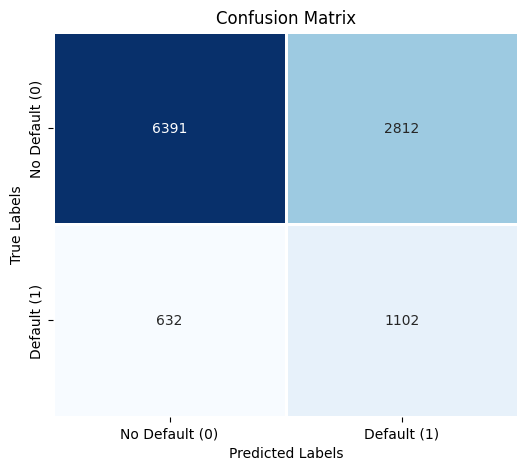

,Metric,Train,Test
0,Accuracy,0.701246,0.685106
1,Precision,0.301393,0.281553
2,Recall,0.670510,0.635525
3,F1 Score,0.415858,0.390227
4,ROC-AUC,0.755448,0.723265


In [106]:
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

- Accuracy (68%): Similar to Random Forest, showing consistent overall predictions.
- Precision (27%): Identifies defaulters at the same rate as Random Forest, meaning false positives remain similar.
- Recall (62%): Slightly lower than Logistic Regression, meaning more defaulters are missed.
- F1 Score (38%): Balanced between precision and recall, performing on par with Random Forest.
- ROC-AUC (72%): Same as Random Forest, indicating a similar ability to distinguish defaulters from non-defaulters.

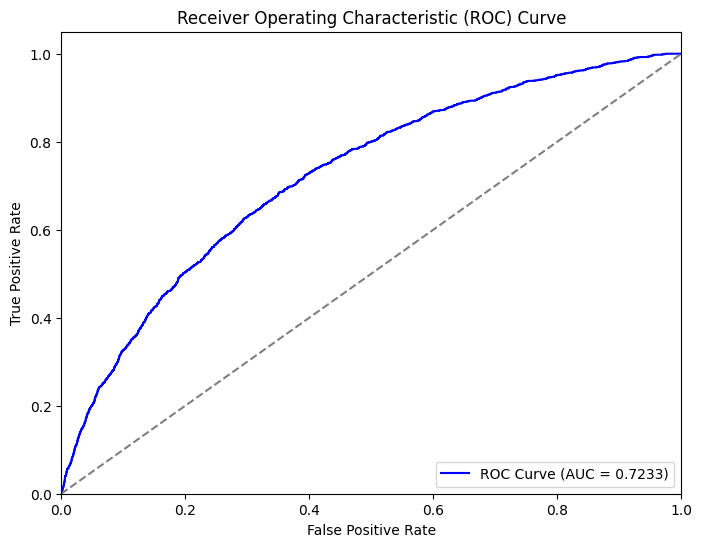

In [107]:
plot_roc_curve(rf_model, X_test, y_test)

AUC = 0.7179, meaning the model correctly distinguishes defaulters from non-defaulters ~71.8% of the time. Similar to logistic & random forest model

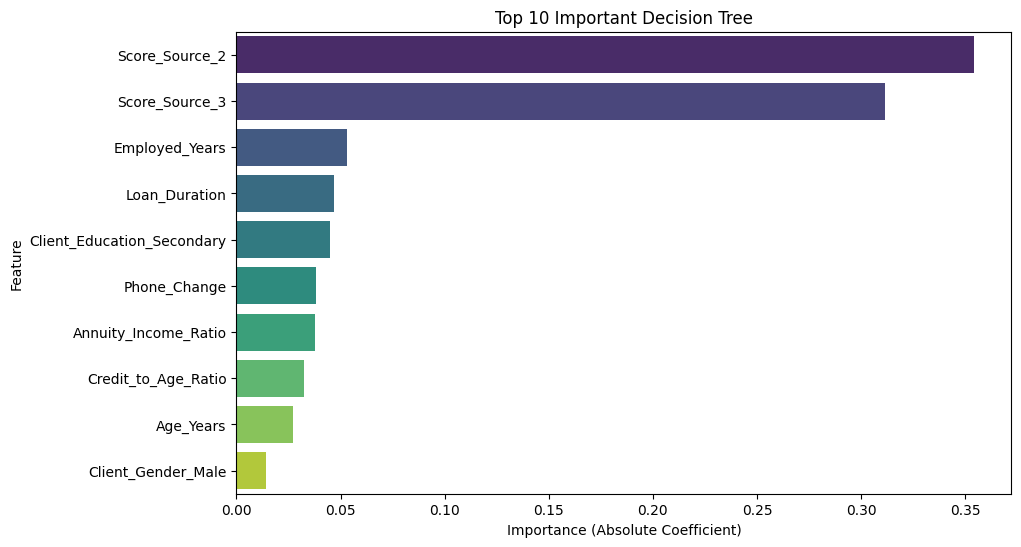

In [110]:
feature_importance_dt = pd.DataFrame({
    "Feature": X_train.columns,  
    "Importance": dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt.head(10), palette='viridis')
plt.title('Top 10 Important Decision Tree')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.show()


## 11. Comparative Analysis

In this analysis, we applied multiple machine learning models to predict loan default risk and evaluated their performance using key metrics such as accuracy, precision, recall, F1-score, and ROC-AUC. Below is a comparative analysis of the models used.

**Logistic Regression:**
- Best recall (65%), meaning it captures more defaulters compared to other models.
- Provides probability scores, making it useful for risk assessment.
- Limited by linearity – May not capture complex relationships in the data.

**Decision Tree:**
- Simple & interpretable, making it easy for business decision-making.
- Captures non-linear relationships but prone to overfitting.
- Lower recall (61.7%), missing some defaulters.

**Random Forest:**
- More stable & robust than Decision Tree by averaging multiple trees.
- Handles non-linearity well and reduces overfitting.
- Similar recall (61.7%) to Decision Tree, meaning it still misses some defaulters.

**Business Impact & Model Selection**

We will go with the Logistic Regression model for better interpretability and decision-making with stakeholders. Since it provides probability scores, it allows the NBFI to assess risk levels and make informed credit decisions. Additionally, Logistic Regression performs well in recall, ensuring that more defaulters are correctly identified, which is crucial for minimizing financial losses.

For scenarios where explainability is essential, the Decision Tree model can be useful, as it offers clear decision rules that are easy to interpret. However, it is prone to overfitting, making it less reliable in generalizing to unseen data.

To improve predictive stability and accuracy, Random Forest is a suitable alternative. By averaging multiple decision trees, it provides a more robust and generalized model, handling non-linear relationships in the data effectively.

## 12. Conclusion

In this project, we developed and evaluated multiple machine learning models to predict vehicle loan defaults for a Non-Banking Financial Institution (NBFI). The objective was to build a data-driven credit risk assessment system that helps in identifying high-risk clients and enables better loan approval decisions.


**Key Findings & Insights**

- Data Processing & Feature Engineering

We cleaned the dataset by handling missing values, outliers, and categorical encoding.
Important financial ratios like Debt-to-Income Ratio, Annuity-to-Income Ratio, and Employment-to-Age Ratio were derived to enhance model performance.
Feature selection helped in removing irrelevant variables, improving both efficiency and accuracy.

- Handling Imbalanced Data

Since the dataset was highly imbalanced (majority non-defaulters), we applied undersampling to ensure the model learns patterns for both defaulters and non-defaulters effectively.

- Model Comparison & Performance Evaluation

Logistic Regression, Decision Tree, and Random Forest were tested to identify the best-performing model.
Logistic Regression achieved the highest recall (65%), meaning it was the best at capturing actual defaulters, which is crucial for risk management.
Random Forest and Decision Tree performed similarly (~68% accuracy, ~72% ROC-AUC) but were more prone to overfitting without proper tuning.

- Interpretability & Business Impact

Logistic Regression was chosen as the final model due to its probability-based decision-making, which allows the NBFI to assess risk levels for each applicant.
Random Forest provided useful insights on feature importance, highlighting that external credit scores (Score_Source_3, Score_Source_2) and employment history (Employed_Days) are the strongest predictors of default.

## 13. Business Implementation & Impact

- Improved Loan Approval Process:

The model can be used to assign risk scores to applicants, helping loan officers make more informed lending decisions.
Threshold-based approvals can be set, where applicants with higher risk probabilities undergo additional screening or require stricter loan terms.

- Reduction in Financial Losses:

By catching more defaulters early, the institution can prevent risky loans from being approved, thereby reducing non-performing assets (NPA).
The recall-focused approach ensures fewer missed defaulters, minimizing financial exposure.

- Enhanced Credit Risk Strategy:

The insights from feature importance analysis can be used to refine lending policies (e.g., giving more weight to credit scores, employment duration, and debt-to-income ratios).
Periodic model retraining will ensure that the system adapts to changing financial behaviors and remains reliable over time.

## 14. References

1. Scikit-learn Documentation
Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830. Retrieved from https://scikit-learn.org/stable/

2. Logistic Regression Documentation
Scikit-learn Developers. (n.d.). Logistic Regression - Scikit-learn Documentation. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

3. Random Forest Classifier Documentation
Scikit-learn Developers. (n.d.). Random Forest Classifier - Scikit-learn Documentation. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

4. Upsampling Techniques for Imbalanced Data
Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321-357. Retrieved from https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

5. ChatGPT as an AI Writing Assistant
OpenAI. (2023). ChatGPT: Optimizing Language Models for Dialogue. Retrieved from https://openai.com/research/chatgpt

6. Flask Framework for Model Deployment
Grinberg, M. (2018). Flask Web Development: Developing Web Applications with Python. O'Reilly Media. Retrieved from https://flask.palletsprojects.com/en/2.0.x/

7. Handling Imbalanced Data: A Review
He, H., Bai, Y., Garcia, E. A., & Li, S. (2008). ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning. IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), 1322-1328. Retrieved from https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html

8. Evaluation Metrics for Classification Models
Saito, T., & Rehmsmeier, M. (2015). The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets. PLOS ONE, 10(3), e0118432. Retrieved from https://doi.org/10.1371/journal.pone.0118432